In [1]:

from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Sequential,Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate, InputSpec
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import regex as re
import pickle
import numpy as np

from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K

In [2]:
import pandas as pd
import tensorflow as tf

## 训练集词向量化
#载入一些helper函数
import sys 
sys.path.append("..") 
from utils import data_helper

X, Y = data_helper.load_preprocessed_data_from_csv(
            "../data/train/labeled_data_processed.csv", with_Y=True, onehot=True)
MAX_NUM_WORDS = 100000 # 最多保留不同词语词数，频率从大到小
MAX_SEQUENCE_LEN = 256
EMBEDDING_DIM=128

X, _ = data_helper.tokenize(
            lang=X, mode='load', path='../data/tokenizer.pickle', max_num_words=MAX_NUM_WORDS,  max_sequence_len=MAX_SEQUENCE_LEN)
print(X.shape)
print(Y.shape)

** Load tokenzier from:  ../data/tokenizer.pickle
** Total different words: 143800.
(7000, 256)
(7000, 7)


In [3]:
from attention import Attention

DROUPOUT=0.2
RECURRENT_DROPOUT=0.2
UNITS=128

In [4]:
## lstm+attention 搭建
model= Sequential([Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X.shape[1]),
      SpatialDropout1D(DROUPOUT),
      LSTM(128, input_shape=(X.shape[1], 1), return_sequences=True),
      Attention(), # <--------- here.
      Dense(Y.shape[1], activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 128)          12800000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256, 128)          131584    
_________________________________________________________________
attention_score_vec (Dense)  (None, 256, 128)          16384     
_________________________________________________________________
last_hidden_state (Lambda)   (None, 128)               0         
_________________________________________________________________
attention_score (Dot)        (None, 256)               0         
_________________________________________________________________
attention_weight (Activation (None, 256)               0

In [5]:
# callbacks
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

callbacks=[]
# callbacks.append(early_stopping)

In [6]:
# train model
EPOCHS=4
BATCH_SIZE=64

VAL_SPLIT=0.1

history = model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=VAL_SPLIT,
                    callbacks=callbacks)

Epoch 1/4
99/99 [==============================] - 35s 355ms/step - loss: 1.2214 - accuracy: 0.5052 - val_loss: 0.4663 - val_accuracy: 0.8529
Epoch 2/4
99/99 [==============================] - 39s 390ms/step - loss: 0.2212 - accuracy: 0.9371 - val_loss: 0.2795 - val_accuracy: 0.9171
Epoch 3/4
99/99 [==============================] - 38s 386ms/step - loss: 0.0423 - accuracy: 0.9889 - val_loss: 0.2628 - val_accuracy: 0.9229
Epoch 4/4
99/99 [==============================] - 41s 415ms/step - loss: 0.0138 - accuracy: 0.9965 - val_loss: 0.2985 - val_accuracy: 0.9229


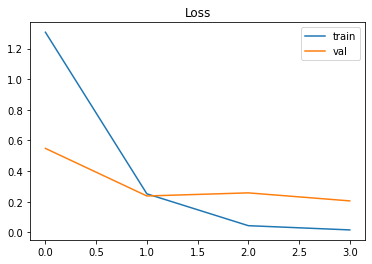

In [11]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

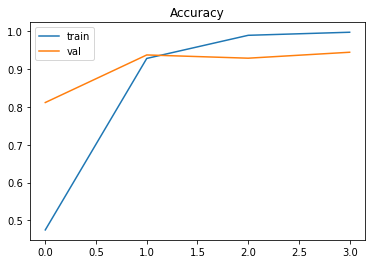

In [9]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [ ]:
## 保存模型

In [7]:
#在测试集上输出结果
test_ds='../data/test_data.csv'
test_df=pd.read_csv(test_ds)[['content']]
## 大于4k 长度的比例
#print(len(test_df[test_df['content'].str.len()>4000]['content'])/len(test_df))
## 截断到 4k
idxs=test_df.loc[test_df['content'].str.len()>4000].index
#print(test_df.loc[test_df['content'].str.len()>4000].index)
test_df.loc[test_df['content'].str.len()>4000,'content']=test_df.loc[test_df['content'].str.len()>4000,'content'].apply(lambda x:x[:4000].rsplit('。',1)[0])
print(len(test_df[test_df['content'].str.len()>4000]['content'])/len(test_df))


#删除除字母,数字，汉字以外的所有符号删除除字母,数字，汉字以外的所有符号
test_df['cleaned_content']=test_df['content'].apply(data_helper.remove_punctuation)
test_df.sample(10)

0.0


,content,cleaned_content
4286,家居建材超市遭遇中国式尴尬 掀起行业革命打破旧的体制，这是所有行业都必须经历的发展过程。然而...,家居建材超市遭遇中国式尴尬掀起行业革命打破旧的体制这是所有行业都必须经历的发展过程然而一个怪...
12455,威廉王子婚礼官方餐具“中国制造”该公司将于本月中旬完成这批瓷器的生产，工人们非常高兴看到这笔...,威廉王子婚礼官方餐具中国制造该公司将于本月中旬完成这批瓷器的生产工人们非常高兴看到这笔订单让...
8244,昔日达拉斯牛魔王欲重回赛场 老芬利：我想打篮球新浪体育讯北京时间3月6日消息，据ESPN报道...,昔日达拉斯牛魔王欲重回赛场老芬利我想打篮球新浪体育讯北京时间3月6日消息据ESPN报道21世...
17993,崔世安成澳门第三任行政长官唯一候选人中广网北京6月17日消息(记者宋薇) 澳门特区政府前社会...,崔世安成澳门第三任行政长官唯一候选人中广网北京6月17日消息记者宋薇澳门特区政府前社会文化司...
1366,组图：2010年全球最会穿的十位美人导语：美国《PEOPLE》杂志近日发布了2010年度好莱...,组图2010年全球最会穿的十位美人导语美国PEOPLE杂志近日发布了2010年度好莱坞最会穿...
8586,华夏基金公司获6项大奖黄宾 程亮亮 谢潞锦昨日，由“理柏中国”举办、第一财经以及新浪财经协办...,华夏基金公司获6项大奖黄宾程亮亮谢潞锦昨日由理柏中国举办第一财经以及新浪财经协办的理柏中国基...
3022,《文明online》酷暑下火逐级送礼火热的7月即将离去，但是超人气即时战斗手机网游《文明on...,文明online酷暑下火逐级送礼火热的7月即将离去但是超人气即时战斗手机网游文明online...
5965,张钧放豪言 业之峰5年要卖50亿一年之前，在业内人士的争议和观望中，北五环外的“峰格汇”登场...,张钧放豪言业之峰5年要卖50亿一年之前在业内人士的争议和观望中北五环外的峰格汇登场作为装饰公...
12499,超值长焦特价促销 富士S1500仅卖1450元 河北行情 富士S1500(资料 报价 ...,超值长焦特价促销富士S1500仅卖1450元河北行情富士S1500资料报价图片论坛强大的变焦...
19597,娇小女星背大SIZE包包就是优雅红爆一时LV的樱桃包，如此震撼地出现在我们眼前，造型可爱的樱...,娇小女星背大SIZE包包就是优雅红爆一时LV的樱桃包如此震撼地出现在我们眼前造型可爱的樱桃在...


In [9]:
import jieba as jb
### 加载停用词
stopwords = data_helper.get_stopwords_list("../data/baidu_stopwords.txt")
# 文本获取停用词
test_df['cuted_content']=test_df['cleaned_content'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
test_df.sample(10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/3n/5ywx4mgd3pz_9d58sjqmrxdm0000gn/T/jieba.cache
Loading model cost 0.974 seconds.
Prefix dict has been built successfully.


,content,cleaned_content,cuted_content
14077,媒体称法国议长将破例访华修复中法关系环球时报特约记者唐湘报道 3月13日上午，十一届全国人大...,媒体称法国议长将破例访华修复中法关系环球时报特约记者唐湘报道3月13日上午十一届全国人大第二...,媒体 称 法国 议长 破例 访华 修复 中法关系 环球时报 特约记者 唐湘 报道 3 月 1...
12694,冯小刚获赠杭州西溪别墅 一部《非诚勿扰》，让很多观众知道了杭州西溪，西溪湿地公园因此游客暴增...,冯小刚获赠杭州西溪别墅一部非诚勿扰让很多观众知道了杭州西溪西溪湿地公园因此游客暴增景区一直有...,冯小刚 获赠 杭州 西溪 别墅 一部 非诚 勿扰 很多 观众 杭州 西溪 西溪 湿地 公园 ...
6038,布局钢铁产业振兴规划 指数基金有望先尝甜头晨报记者 陈重博昨日，钢铁板块指数大涨3.86%，...,布局钢铁产业振兴规划指数基金有望先尝甜头晨报记者陈重博昨日钢铁板块指数大涨386在权重股中可...,布局 钢铁产业 振兴 规划 指数 基金 有望 先 尝甜头 晨报 记者 陈重博 昨日 钢铁 板...
9017,《幻想-全面战争》战场无敌鳞宠攻略《幻想-全面战争》里的众多宠物中鳞宠一直被玩家所冷落，即使...,幻想全面战争战场无敌鳞宠攻略幻想全面战争里的众多宠物中鳞宠一直被玩家所冷落即使有人抓到高属鳞...,幻想 全面战争 战场 无敌 鳞 宠 攻略 幻想 全面战争 里 众多 宠物 中鳞宠 玩家 冷落...
13606,钻石未归休城又添伤号 风雨飘摇这样的火箭伤不起新浪体育讯北京时间3月16日(休斯敦时间3月1...,钻石未归休城又添伤号风雨飘摇这样的火箭伤不起新浪体育讯北京时间3月16日休斯敦时间3月15日...,钻石 未归 休城 添 伤号 风雨飘摇 火箭 伤不起 新浪 体育讯 北京 时间 3 月 16 ...
4211,海外视角：去世后博客或Q币等如何处理？随着网络日益进入人们生活，越来越多的人拥有信箱、博客等...,海外视角去世后博客或Q币等如何处理随着网络日益进入人们生活越来越多的人拥有信箱博客等个人空间...,海外 视角 去世 后 博客 Q 币 网络 日益 生活 越来越 人 拥有 信箱 博客 个人空间...
931,组图：变身Fashion Icon紧跟十大潮流关键词导语：如果你踌躇于自己的衣橱前，为今季秋...,组图变身FashionIcon紧跟十大潮流关键词导语如果你踌躇于自己的衣橱前为今季秋冬还需添...,组图 变身 FashionIcon 紧跟 十大 潮流 关键词 导语 踌躇 衣橱 前为 今季 ...
4466,服务规范有待完善 家居行业发展更需关注细节很多有过装修经验的细心人都会注意到一个环节，在品牌...,服务规范有待完善家居行业发展更需关注细节很多有过装修经验的细心人都会注意到一个环节在品牌家电...,服务 规范 有待 完善 家居 行业 发展 更 需 关注 细节 很多 有过 装修 经验 细心人...
6566,80G硬盘高清DV 索尼XR100E降至5250元 [北京行情] 索尼HDR-XR10...,80G硬盘高清DV索尼XR100E降至5250元北京行情索尼HDRXR100E是一款新上市不...,80G 硬盘 高清 DV 索尼 XR100E 降至 5250 元 北京 行情 索尼 HDRX...
17634,房企抢地王只为圈钱 地方政府开场白欢迎地王2009年上半年，“抢地王是因为有钱”，2009年...,房企抢地王只为圈钱地方政府开场白欢迎地王2009年上半年抢地王是因为有钱2009年下半年抢地...,房企抢 地王 只 圈钱 地方 政府 开场白 地王 2009 年 上半年 抢 地王 是因为 有...


In [10]:
#X,_=data_helper.tokenize(test_df['cuted_content'].values,MAX_NUM_WORDS,MAX_SEQUENCE_LEN)
X,_=data_helper.tokenize(test_df['cuted_content'], mode='load', path='../data/tokenizer.pickle',max_sequence_len=MAX_SEQUENCE_LEN)
print(X.shape)

** Load tokenzier from:  ../data/tokenizer.pickle
** Total different words: 143800.
(20000, 256)


In [ ]:
y_pred=model.predict(X)
y_pred1 = y_pred.argmax(axis = 1)
print(y_pred1.shape)

In [ ]:
#{0: '家居', 1: '房产', 2: '教育', 3: '时尚', 4: '时政', 5: '科技', 6: '财经',7: '游戏',8: '娱乐',9: '体育'}
#7类，分别为：财经、房产、家居、教育、科技、时尚、时政
#10个类别:财经、房产、家居、教育、科技、时尚、时政、游戏、娱乐、体育。
#{0: '可公开', 1: '低风险', 2: '中风险', 3: '高风险'}
#rank_label对应关系:0{0,8,9} 1{2,3,7} 2{1,5} 3{4,6}
def reflect_rank(line):
    res=-1
    if(line==0 or line==8 or line==9):
        res=0
    elif(line==2 or line==3 or line==7):
        res=1
    elif(line==1 or line==5):
        res=2
    elif(line==4 or line==6):
        res=3
    return res

cn_class_dic={0: '家居', 1: '房产', 2: '教育', 3: '时尚', 4: '时政', 5: '科技', 6: '财经',7: '游戏',8: '娱乐',9: '体育'}
cn_rank_dic={0: '可公开', 1: '低风险', 2: '中风险', 3: '高风险'}

def cn_class_label(line):
    return cn_class_dic[line]

def cn_rank_label(line):
    return cn_rank_dic[line]

In [ ]:
#id class_label rank_label

test_pr=pd.DataFrame(y_pred1)
test_pr.columns = ['class_label']
test_pr['rank_label']=test_pr['class_label'].apply(reflect_rank)
test_pr['class_label']=test_pr['class_label'].apply(cn_class_label)
test_pr['rank_label']=test_pr['rank_label'].apply(cn_rank_label)#id class_label rank_label

test_pr=pd.DataFrame(y_pred1)
test_pr.columns = ['class_label']
test_pr['rank_label']=test_pr['class_label'].apply(reflect_rank)
test_pr['class_label']=test_pr['class_label'].apply(cn_class_label)
test_pr['rank_label']=test_pr['rank_label'].apply(cn_rank_label)

In [ ]:
test_pr.to_csv('submission.csv',index_label='id')

In [ ]:
y_pred=model.predict(X)
y_pred1 = y_pred.argmax(axis = 1)